<h4> Imports </h4>

In [84]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import Lambda, Dense, LSTM, Input, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

from prophet import Prophet
from prophet.diagnostics import performance_metrics
import yfinance as yf
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

<h5> 0. Data import </h5>

No longer used, switched to using yahoo finance data!

In [2]:
def get_data(start_date, end_date, ticker, df):
    idx = pd.IndexSlice
    new_df = df.loc[idx[start_date:end_date, ticker], :]
    return new_df

df = (pd.read_csv('data/wiki_stocks.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())


<h4> 1. Time series naive </h4>
Wrapper function for all models using naive time series data (predicting price)

<h5> 1.1 ARIMA </h5>

In [2]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
# Make a function to evaluate different ARIMA models with several different p, d, and q values.

def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.10f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.10f' % (best_cfg, best_score))

In [ ]:
# Now, we choose a couple of values to try for each parameter.
# p_values = [x for x in range(0, 3)]
# d_values = [x for x in range(0, 3)]
# q_values = [x for x in range(0, 3)]

# import warnings
# warnings.filterwarnings("ignore")
# evaluate_models(arima_log, p_values, d_values, q_values)

In [7]:
def ts_arima(data):
    # Calculate ARIMA w/ TS data and print results / return results
    log_dat = np.log(data['Open'])

    model = ARIMA(log_dat, order=(0, 2, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(24)

    print(model_fit.summary())

    preds = model_fit.predict()

    final_preds = np.exp(preds)

    plt.figure(figsize=(15,10))
    plt.plot(final_preds[2:], color = 'red')
    plt.plot(data['Open'][2:])

    mse = mean_squared_error(preds, log_dat)
    print("MSE: ", mse)

    return model, mse

<h5> 1.2 RNN </h5>

In [8]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [21]:
def ts_rnn(data):
    # Calculate rnn w/ TS data and print results / return results

    results_path = Path('results', 'univariate_time_series')
    if not results_path.exists():
        results_path.mkdir(parents=True)

    dat = data[['Open']]

    scaler = MinMaxScaler()
    scaled_data = pd.Series(scaler.fit_transform(dat).squeeze(), index=dat.index)

    window_size = 63

    ### Train-test split ###

    X, y = create_univariate_rnn_data(scaled_data, window_size=window_size)

    split=int(len(scaled_data) * 0.8) 

    ### Train on data up to 2018 ###
    X_train = X[:split].values.reshape(-1, window_size, 1)
    y_train = y[:split]

    ### Test on data from 2019 ###
    X_test = X[split:len(scaled_data)].values.reshape(-1, window_size, 1)
    y_test = y[split:len(scaled_data)]

    n_obs, window_size, n_features = X_train.shape

    rnn = Sequential([
        LSTM(units=10, 
            input_shape=(window_size, n_features), name='LSTM'),
        Dense(1, name='Output')
    ])

    ### Define optimizer for RNN ###

    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                        rho=0.9,
                                        epsilon=1e-08,
                                        decay=0.0)

    ### Compile RNN w/ previously defined optimizer ###
    rnn.compile(loss='mean_squared_error', 
                optimizer=optimizer)

    ### Save best path of model during training ###
    rnn_path = (results_path / 'rnn.h5').as_posix()

    ### Call best model during training ###
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                                verbose=0,
                                monitor='val_loss',
                                save_best_only=True)

    ### Early stopping to prevent overfitting ###
    early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=20,
                                restore_best_weights=True)

    ### Train model ###
    lstm_training = rnn.fit(X_train,
                            y_train,
                            epochs=150,
                            batch_size=20,
                            shuffle=True,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=0)

    ### More performance benchmarks ###

    train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
    test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
    print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

    ### We trained on scaled data, therefore our predictions are in scaled form ###
    train_predict_scaled = rnn.predict(X_train)
    test_predict_scaled = rnn.predict(X_test)

    ### Correlation coefficient between predicted and actual values ###
    train_ic = spearmanr(y_train, train_predict_scaled)[0]
    test_ic = spearmanr(y_test, test_predict_scaled)[0]
    print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

    test_predict_unscaled = scaler.inverse_transform(test_predict_scaled)
    y_test_unscaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    plt.figure(figsize=(15,10))
    plt.plot(test_predict_unscaled[1:], color = 'red')
    plt.plot(y_test_unscaled[1:])

    mse = mean_squared_error(test_predict_unscaled, y_test_unscaled)

    print("MSE: ", mse)

    return rnn, mse

<h5> 1.3 Gradient Boosting </h5>

In [103]:
def ts_gb(data):
    # Calculate XGBoost w/ TS data and print results / return results

    data = data.reset_index()
    data["Year"] = data['Date'].dt.year
    data["Month"] = data['Date'].dt.month
    data["Day"] = data['Date'].dt.day
    data["Next Open"] = data['Open'].shift(-1)
    split = 0.8

    dates_avail = data["Date"].unique()
    split_date_ind = int(dates_avail.shape[0] * split)
    split_date = dates_avail[split_date_ind]

    train_df = data.query("Date <= @split_date")
    validation_df = data.query("Date > @split_date")
    validation_df = validation_df[:-1]

    features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

    X_train = train_df[features]
    Y_train = train_df['Next Open']

    X_validation = validation_df[features]
    Y_validation = validation_df['Next Open']

    params = {'n_estimators': 500, 'max_depth': 25, 'min_child_weight' : 2,
            'learning_rate': 0.3}
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, 
            Y_train, 
            eval_set = [(X_train, Y_train), (X_validation, Y_validation)], 
            verbose = False)
    model_score = model.score(X_train, Y_train)
    print('R2 sq: ',model_score)
    y_predicted = model.predict(X_validation)

    mse = mean_squared_error(Y_validation.values, y_predicted)
    # The mean squared error
    print("Mean squared error: %.2f"% mse)
    # Explained variance score: 1 is perfect prediction
    print('Test Variance score: %.2f' % r2_score(Y_validation, y_predicted))
    
    plt.figure(figsize=(15,10))
    plt.plot(y_predicted[1:], color = 'red')
    plt.plot(Y_validation.values[1:])

    return model, mse

<h5> 1.4 KNN </h5>

In [106]:
def ts_knn(data):
    # Calculate knn w/ TS data and print results / return results
    data['Open-Close'] = data.Open - data.Close
    data['High-Low'] = data.High - data.Low
    data = data.dropna()

    X = data[['Open-Close', 'High-Low']]

    Y = data['Open'].shift(-1)

    split_percentage = 0.8
    split = int(split_percentage*len(data))

    X_train = X[:split]
    Y_train = Y[:split]

    X_test = X[split:-1]
    Y_test = Y[split:-1]

    # Instantiate KNN learning model(k=15)
    knn = KNeighborsRegressor(n_neighbors=15)

    # fit the model
    knn.fit(X_train, Y_train)

    y_preds = knn.predict(X_test)
    mse = mean_squared_error(y_preds, Y_test)
    print("MSE: ", mse)

    return knn, mse

<h5> 1.5 VAE </h5>

In [108]:
def ts_vae(data):
    # Calculate VAE w/ TS data and print results / return results
    # LSTM VAE

    # https://saturncloud.io/blog/keras-lstmvae-for-timeseries-anomaly-detection-a-comprehensive-guide/
    dat = data[['Open']]

    scaler = MinMaxScaler()
    scaled_data = pd.Series(scaler.fit_transform(dat).squeeze(), index=dat.index)

    window_size = 64

    ### Train-test split ###

    X, y = create_univariate_rnn_data(scaled_data, window_size=window_size)

    split=int(len(scaled_data) * 0.8) 

    ### Train on data up to 2018 ###
    X_train = X[:split].values.reshape(-1, window_size, 1)
    y_train = y[:split]

    ### Test on data from 2019 ###
    X_test = X[split:len(scaled_data)].values.reshape(-1, window_size, 1)
    y_test = y[split:len(scaled_data)]

    # encoder
    latent_dim = 3
    inter_dim = 32
    timesteps, features = 64, 1

    def sampling(args):
        z_mean, z_log_sigma = args
        batch_size = tf.shape(z_mean)[0] 
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
        return z_mean + z_log_sigma * epsilon

    # timesteps, features
    encoder_input = Input(shape= (timesteps, features)) 

    #intermediate dimension 
    encoder_lstm = LSTM(inter_dim, activation='relu')(encoder_input)

    #z_layer
    z_mean = Dense(latent_dim)(encoder_lstm)
    z_log_sigma = Dense(latent_dim)(encoder_lstm)
    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Reconstruction decoder
    decoder1 = RepeatVector(timesteps)(z)
    decoder1 = LSTM(inter_dim, activation='relu', return_sequences=True)(decoder1)
    decoder1 = TimeDistributed(Dense(features))(decoder1)

    ### Early stopping to prevent overfitting ###
    early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=20,
                                restore_best_weights=True)

    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                            rho=0.9,
                                            epsilon=1e-08,
                                            decay=0.0)

    vae = Model(encoder_input, decoder1)
    vae.compile(loss='mse', optimizer=optimizer)

    vae.fit(X_train, 
        X_train, 
        epochs = 150, 
        batch_size=20, 
        validation_data=(X_test, X_test), 
        callbacks=[early_stopping], 
        verbose=0)

    predictions = vae.predict(X_test)

    reshaped = predictions.reshape(len(predictions), 64)
    last_values = reshaped[:, -1]
    predictions_series = pd.Series(last_values)
    predictions_series = predictions_series.values.reshape(440,)

    pred_unscaled = scaler.inverse_transform(predictions_series.reshape(-1, 1))
    y_test_unscaled = scaler.inverse_transform(y_test.values.reshape(-1, 1))

    plt.figure(figsize=(15,10))
    plt.plot(pred_unscaled[1:], color = 'red', label='predictions')
    plt.plot(y_test_unscaled[1:], label='actual')
    plt.legend()

    print("MSE: ", mean_squared_error(pred_unscaled, y_test_unscaled))
    return vae

<h5> 1.6 Prophet </h5>

In [144]:
def ts_prophet(data):
    # Calculate Prophet for seasonality w/ TS data and print results / return results

    data['ds'] = data.index
    data['y'] = data.Open

    prophet_df = data.reset_index()[['ds', 'y', 'High', 'Low', 'Close', 'Volume']]

    split=int(len(prophet_df) * 0.8) 
    df_train = prophet_df[:split]

    df_test = prophet_df[split:len(prophet_df)]

    m = Prophet(daily_seasonality=True)
    m.add_regressor('High')
    m.add_regressor('Low')
    m.add_regressor('Close')
    m.add_regressor('Volume')
    m.add_country_holidays(country_name='USA')
    m.fit(df_train)

    forecast = m.predict(df_test.drop(columns="y"))

    plt.figure(figsize=(15,10))
    plt.plot(forecast[['yhat']][1:], color = 'red', label='predictions')
    plt.plot(df_test[['y']].values[1:], label='actual')
    plt.legend()

    mse = mean_squared_error(forecast[['yhat']], df_test[['y']])
    print("MSE: ", mse)
    
    return m, mse

<h5> 1.7 Ensemble </h5>

In [ ]:
def ts_ensemble(data):
    # Use ensemble of multiple models, some combination of above (NOT RL)
    #  w/ TS data and print results / return results
    return 

In [4]:
def ts_price(model_selection, ticker, date_start, date_end):
    # data = get_data(date_start, date_end, ticker, df)
    data = yf.download(ticker, start=date_start, end=date_end)
    if model_selection == "ARIMA":
        ts_arima(data)
        pass
    elif model_selection == "RNN":
        ts_rnn(data)
        pass
    elif model_selection == "GB":
        ts_gb(data)
        pass
    elif model_selection == "KNN":
        ts_knn(data)
        pass
    elif model_selection == "VAE":
        ts_vae(data)
        pass
    elif model_selection == "PROPHET":
        ts_prophet(data)
        pass
    elif model_selection == "ENSEMBLE":
        ts_ensemble(data)
        pass
    else:
        pass

[*********************100%%**********************]  1 of 1 completed


11:39:41 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing


MSE:  0.09026500972961195


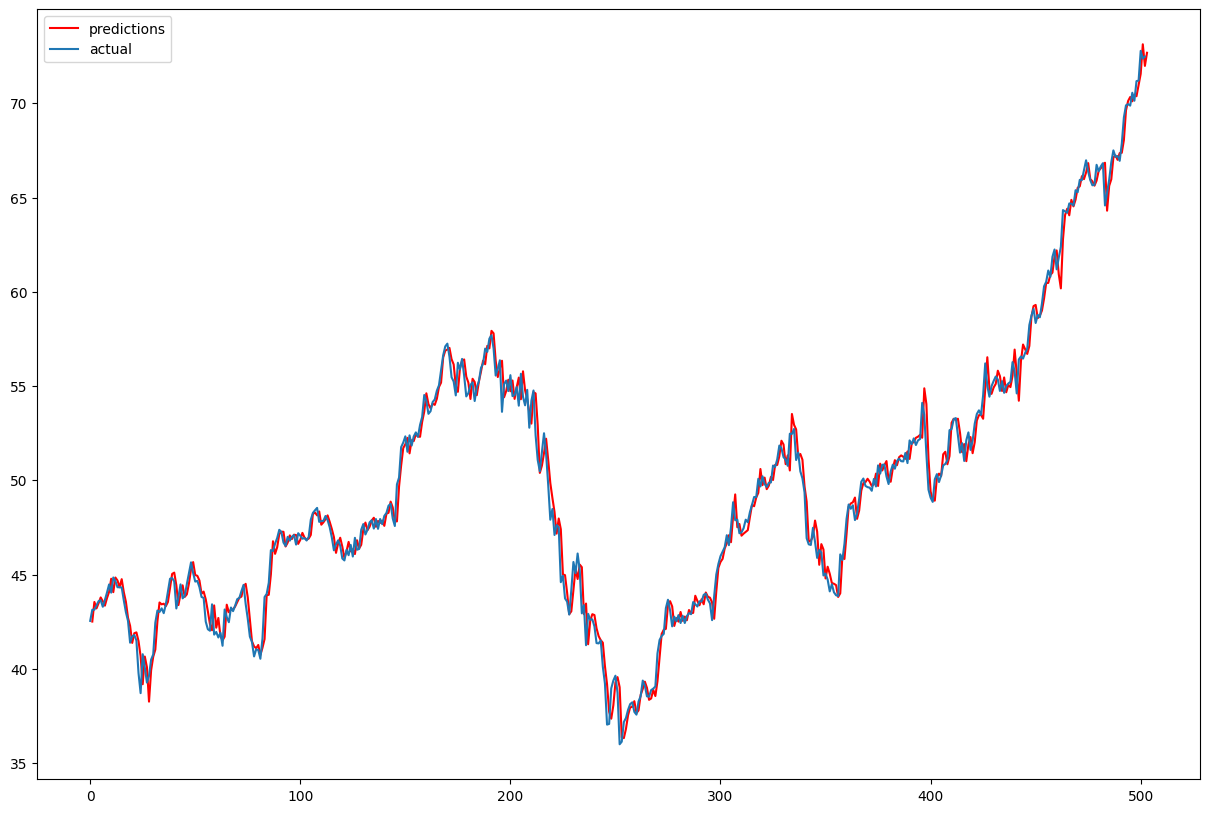

In [146]:
ts_price("PROPHET", "AAPL", '2010-01-01', '2020-01-01')

<h4> 2. Combining other techniques </h4>

<ol>
    <li> Incorporating NLP </li>
    Use twitter data for stocks from previous research
    <li> Use returns for evaluation </li>
    See david's notes. Basically, returns is looking at difference in prices instead of price in one day. For example, open[t] - open[t-1] would be one way to quantify "returns". Wouldn't change models much, just how we deal with the data initially.
    <li> Predicting indicators such as RSI, Momentum </li>
    See stefan jansen's work
    <li> Non-traditional TS models </li>
    For example, clustering methods? Neural transformers? Classification models? Weighted precision and measure for metric

Questions:

How tf does naive bayes work? I've tried Gaussian bayes but running into a lot of issues.
Any sources for RL? Not sure how the rewards system works.

TO-DOS: 

1. Transition to using yahoo finance 
aapl = yf.download("AAPL", start="2020-01-01", end="2021-01-01")

stocks = ["AAPL", "AMZN", "MSFT"]
data = yf.download(stocks, start="2020-01-01", end="2021-01-01")

2. Compile hyperparameter tuning, right now from a bunch of scattered sources, so hard coded in. Add maybe an additional section to grid search or something.

3. Make sure MSE uniform. To do so, ensure data set size is same for all models. Maybe have average MSE by test set size?

4. Make RNN and LSTM VAE multivariate

5. Add function to compare multiple models. Say, add a list of model inputs and print the compared MSE between all of them. Also add an input that allows for "no graphics" to not show plots for the main function, so that there isn't a ton of plots when comparing models.

6. Unscale RNN preds

Future: 

- Add RL
- Add GaussianNB?